In [26]:
from time import time

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import joblib

In [27]:
# import training data
comments = pd.read_csv('C:/Users/aidan/OneDrive/Documents/GitHub/PIC16BProject/reviews.csv')
comments.head(1)

,game,is_Recommended,hours_players,comment
0,MapleStory,Not Recommended,6.8,Posted: March 24\n♥♥♥♥ Nexon. All my homies ha...


In [28]:
comments['comment'] = comments['comment'].apply(lambda x: x[x.find('\n')+1:] if '\n' in x else x) # remove the date from the comment
comments['comment'] = comments['comment'].apply(lambda x: x.replace('\n', ' ') if '\n' in x else x) # replace newlines with spaces so words aren't considered as word + \n
comments = comments.drop(["game","is_Recommended","hours_players"], axis=1)

comments = comments.sample(frac = 1)

comments.head(1)

,comment
7794,EARLY ACCESS REVIEW I just finished the game 1...


In [4]:
# model parameters
n_samples = len(comments['comment']) # use all the training comments
n_components = 50 # generate 50 topics
n_top_words = 10 # display each topic's top 10 words in the graph
batch_size = 2048 # consider batches of 2048 comments
iterations = 5000 # run 5000 iterations max
init = "nndsvda" # non-negative initialization function

In [45]:
# function to build visual topic representation once model has run
# displays all topics and the top 10 words and teir importance to the topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(10, 5, figsize=(60, 60), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [30]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(comments["comment"])
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.814s.




 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=9588, batch_size=2048...


C:\Users\aidan\anaconda3\envs\PIC16B\lib\site-packages\sklearn\decomposition\_nmf.py:2288: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


done in 3050.218s.


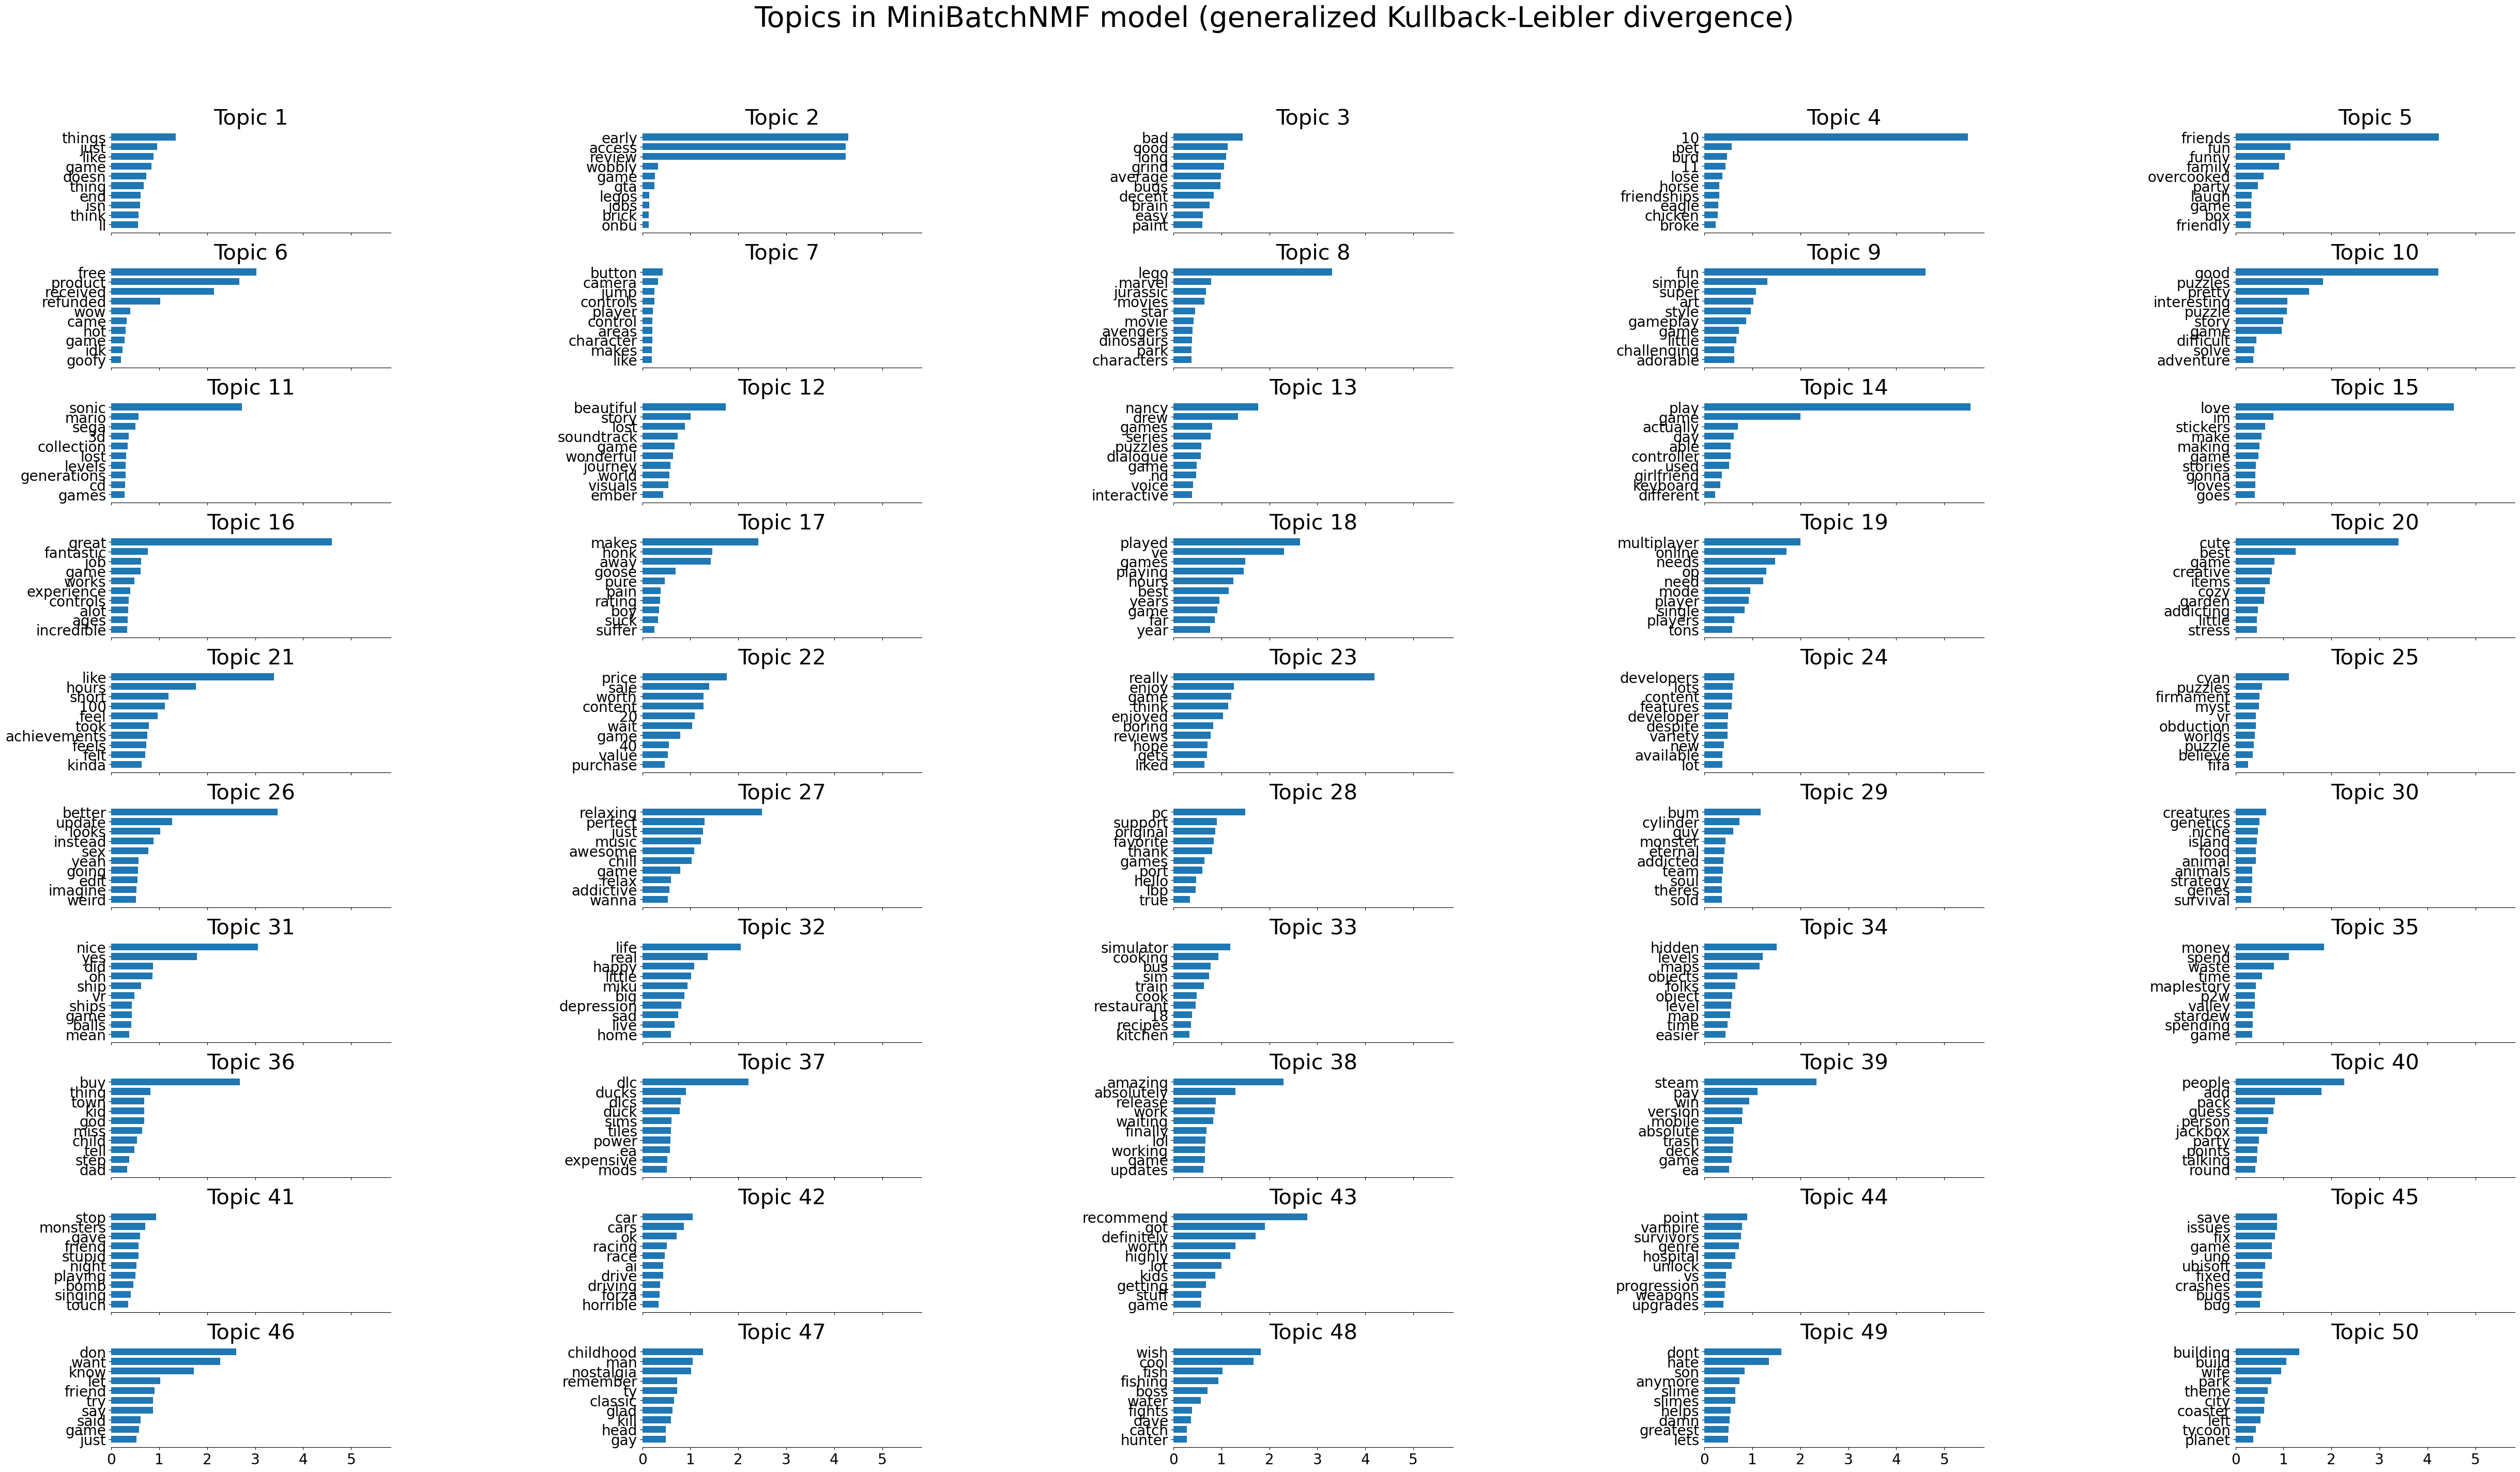

In [31]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d, "
    "batch_size=%d..." % (n_samples, batch_size),
)
t0 = time()
mbnmfkl = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    max_iter = iterations,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [38]:
# Now we can test a new game's comments on the model before we export the model for future use

#input comments for model analysis
new_comments = pd.read_csv('undertale.csv')
new_comments['comment'] = new_comments['comment'].apply(lambda x: x[x.find('\n')+1:] if '\n' in x else x) # remove the date from the comment
new_comments['comment'] = new_comments['comment'].apply(lambda x: x.replace('\n', ' ') if '\n' in x else x) # replace newlines with spaces so words aren't considered as word + \n
new_comments = new_comments.drop(["game","hours_players"], axis=1)

le = LabelEncoder()
new_comments["is_Recommended"] = le.fit_transform(new_comments["is_Recommended"])

new_comments = new_comments.sample(frac = 1)

new_comments.head(1)

,is_Recommended,comment
89,0,You should totally play this if you enjoy; -Ea...


In [39]:
# Vectorize the new text using the same vectorizer used for training
new_text_tfidf = tfidf_vectorizer.transform(new_comments["comment"])

# Infer topics with the MBNMFKL model
new_text_topics_mbnmfkl = mbnmfkl.transform(new_text_tfidf)

# Display the results
print("MBNMF Topics for the New Text:")
nttma = np.array(new_text_topics_mbnmfkl)
print(np.mean(nttma, axis=0).round(5))

MBNMF Topics for the New Text:
[0.00605 0.00155 0.01274 0.00272 0.00277 0.00277 0.00325 0.00097 0.00365
 0.0035  0.00057 0.00455 0.0019  0.00752 0.00221 0.00325 0.0025  0.00625
 0.0014  0.00154 0.00469 0.00135 0.00352 0.00234 0.00082 0.00279 0.00151
 0.00136 0.00243 0.00154 0.00208 0.00332 0.00075 0.00119 0.00131 0.00266
 0.00084 0.00379 0.00123 0.00126 0.00376 0.00082 0.00201 0.00166 0.00107
 0.00494 0.0026  0.00153 0.00126 0.00117]


In [40]:
#create list of zeros to tally comment contribution to each topic
MBNMFKLtopics = np.zeros((50,), dtype=int)
LDAtopics = np.zeros((50,), dtype=int)

# +/- 1 for each comment's most relevant topic based on the associated sentiment
for i in range(len(new_comments["comment"])):
    if new_comments["is_Recommended"][i] == 0:
        MBNMFKLtopics[np.argmax(new_text_topics_mbnmfkl[i])] += 1
    elif new_comments["is_Recommended"][i] == 1:
        MBNMFKLtopics[np.argmax(new_text_topics_mbnmfkl[i])] -= 1

# display all topic scores
for i in range(len(MBNMFKLtopics)):
    print("MB Topic " + str(i) + ": " + str(MBNMFKLtopics[i]))

MB Topic 0: 37
MB Topic 1: 5
MB Topic 2: 12
MB Topic 3: 4
MB Topic 4: 3
MB Topic 5: 7
MB Topic 6: 4
MB Topic 7: 2
MB Topic 8: 3
MB Topic 9: 7
MB Topic 10: 0
MB Topic 11: 6
MB Topic 12: 2
MB Topic 13: 19
MB Topic 14: 4
MB Topic 15: 4
MB Topic 16: 1
MB Topic 17: 8
MB Topic 18: 3
MB Topic 19: 2
MB Topic 20: 12
MB Topic 21: 0
MB Topic 22: 7
MB Topic 23: 1
MB Topic 24: 2
MB Topic 25: 3
MB Topic 26: 1
MB Topic 27: 0
MB Topic 28: 1
MB Topic 29: 1
MB Topic 30: 4
MB Topic 31: 6
MB Topic 32: 0
MB Topic 33: 2
MB Topic 34: 0
MB Topic 35: 2
MB Topic 36: 2
MB Topic 37: 4
MB Topic 38: 1
MB Topic 39: 1
MB Topic 40: 3
MB Topic 41: 1
MB Topic 42: 3
MB Topic 43: 0
MB Topic 44: 1
MB Topic 45: 9
MB Topic 46: 6
MB Topic 47: 3
MB Topic 48: 0
MB Topic 49: 1


In [41]:
# check the scores of each topic for current game
print(MBNMFKLtopics)

[37  5 12  4  3  7  4  2  3  7  0  6  2 19  4  4  1  8  3  2 12  0  7  1
  2  3  1  0  1  1  4  6  0  2  0  2  2  4  1  1  3  1  3  0  1  9  6  3
  0  1]


In [42]:
# fashion export files of both the topic model and the vectorizer layer so it can be applied to new data
mbnmfkl_sav_file = "comment_topic_model.sav"
tfidf_sav_file = "comment_tfidf.sav"

with open(mbnmfkl_sav_file, 'wb') as file:
    joblib.dump(mbnmfkl, file)

with open(tfidf_sav_file, 'wb') as file:
    joblib.dump(tfidf_vectorizer, file)